In [536]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import stardate as sd
# from stardate.lhf import calc_bv, gyro_model_rossby, gyro_model

from isochrones import StarModel, get_ichrone
bands = ["B", "V", "J", "H", "K", "BP", "RP"]
mist = get_ichrone("mist", bands=bands)

We're going to explore what the likelihood function looks like.

In [562]:
def convective_overturn_time(*args):
    """Estimate the convective overturn time.

    Estimate the convective overturn time using equation 11 in Wright et al.
    (2011): https://arxiv.org/abs/1109.4634
    log tau = 1.16 - 1.49log(M/M⊙) - 0.54log^2(M/M⊙)

    Args:
        args: EITHER mass (float): Mass in Solar units OR eep (float):
            The Equivalent evolutionary point of a star (355 for the Sun),
            age (float): The age of a star in log_10(years) and feh (float):
            the metallicity of a star.

    Returns:
        The convective overturn time in days.

    """

    if len(args) > 1:
        # Convert eep, age and feh to mass (mass will be in Solar mass units)
        eep, age, feh = args
        M = mist.interp_value([eep, age, feh], ["mass"])
    else:
        M = args[0]

    log_tau = 1.16 - 1.49*np.log10(M) - .54*(np.log10(M))**2
    return 10**log_tau


def calc_bprp(mag_pars):
    """Calculate a G_bp-G_rp colour from stellar parameters.

    Calculate bp-rp colour from stellar parameters [EEP, log10(age, yrs), feh,
    distance (in parsecs) and extinction] using MIST isochrones.

    Args:
        mag_pars (list): A list containing EEP, log10(age) in years,
            metallicity, distance in parsecs and V-band extinction, Av, for a
            star.

    Returns:
        G_bp - G_rp color.

    """
    _, _, _, bands = mist.interp_mag([*mag_pars], ["BP", "RP"])
    bp, rp = bands
    return bp - rp

Define the new gyro model.

In [563]:
def period_model(params, log10_bprp, log10_age):
    """
    Predicts log10 rotation period from log10 color and log10 age.
    
    Args:
        params (list): The list of model parameters.
        log10_bprp (array): The (log10) G_bp - G_rp color array.
        log10_age (array): The (log10) age array.
    Returns:
        log10_period (array): The (log10) period array.
    """
    return np.polyval(params[:20], log10_bprp) + params[20]*log10_age


def age_model(params, log10_bprp, log10_period):
    """
    Predicts log10 age from log10 color and log10 period.
    
    Args:
        params (list): The list of model parameters.
        log10_bprp (array): The (log10) G_bp - G_rp color array.
        log10_period (array): The (log10) period array.
    Returns:
        log10_age (array): The (log10) age  array.
    """
    return (log10_period - np.polyval(params[:20], log10_bprp))/params[20]

def variance(p, log10_bprp, eep, log10_period_err):
    z = eep/100.
    return (log10_period_err + np.polyval(p[21:24], log10_bprp) + np.polyval(p[24:], z))**2

# Test these models with Solar values
par = [-368.45643784860033, 695.3279793519738, 396.7318187948002,
              -913.8941676968989, -4.285360945342232, -633.8313260304885,
              375.86156815716527, 872.4274283682225, -59.29022811073145,
              803.7883055633133, -1179.9434901842233, -1297.5846247255904,
              1230.0129533662775, 559.6239203031654, -443.7932574323561,
              -83.31481638850344, 51.160545174146954, -2.428588637483325,
              0.674925166060539, -5.313426891558643, 0.7081072443768881,
              3.547556067649739, -0.03403261258090268, -3.43848152145279,
              0.3482138491369073, -2.8831675822407044, 7.8290170310554705,
              -3.4384815148170618]


print(10**period_model(par, np.log10(.82), np.log10(4.56*1e9)))
print((10**age_model(par, np.log10(.82), np.log10(26)))*1e-9)

25.995022723535442
4.561233060841473


In [564]:
def gyro_model_rossby(params, log10_age, log10_bprp, mass, Ro_cutoff=2.16, rossby=True):
    """Predict a rotation period from an age, B-V colour and mass.

    Predict a rotation period from an age, B-V color and mass using a gyrochronology 
    model fit to the Praesepe cluster and the Sun with the van Saders et al. (2016)
    weakened magnetic braking correction.

    Args:
        log10_age (array): The log10_ages of stars in years.
        log10_bprp (array): The log10 G_BP - G_RP color of stars.
        mass (array): The mass of stars in Solar masses.
        Ro_cutoff (float, optional): The critical Rossby number after which
            stars retain their rotation period. This is 2.16 in van Saders et
            al. (2016) and 2.08 in van Saders et al. (2018). We adopt a
            default value of 2.16.
        rossby (Optional[bool]): If True (default), the van Saders (2016)
            weakened magnetic braking law will be implemented.

    Returns:
        prot (array): The rotation periods in days.
    """

    log_P = period_model(params, log10_bprp, log10_age)
    
    if not rossby:  # If Rossby model is switched off
        return log_P

    # Otherwise the Rossby model is switched on.
    # Calculate the maximum theoretical rotation period for this mass.
    pmax = Ro_cutoff * convective_overturn_time(mass)

    # Calculate the age at which this star reaches pmax, based on its bp-rp color.
    log10_age_thresh = age_model(params, log10_bprp, np.log10(pmax))

#     # If star older than this age, return maximum possible rotation period.
#     old = log10_age > log10_age_thresh
#     log_P[old] = np.ones(len(log_P[old])) * np.log10(pmax)
        
    return log_P

# Test this model.
print(10**gyro_model_rossby(par, np.array([np.log10(4.56*1e9)]), np.log10(.82), 1.))
print(10**gyro_model_rossby(par, np.array([np.log10(6*1e9)]), np.log10(.82), 1.))
print(10**gyro_model_rossby(par, np.array([np.log10(9*1e9)]), np.log10(.82), 1.))

[25.99502272]
[31.57089982]
[42.07057583]


In [565]:
def lnprob(lnparams, *args):
    params = lnparams*1
    params[3] = np.exp(lnparams[3])
    params = [float(p) for p in params]

    mod, period, period_err, _, _, _, _ = args

    log10_bprp = np.log10(calc_bprp(params))
    if not np.isfinite(log10_bprp):
        return mod.lnlike(params), -np.inf, mod.lnprior(params)
        
    mass = mist.interp_value([params[0], params[1], params[2]], ["mass"])
    
    # Praesepe model parameters. These model parameters were fit to
    # log10(age), log10(period), log10(G_BP - G_RP) and EEP
    p = [-368.45643784860033, 695.3279793519738, 396.7318187948002,
         -913.8941676968989, -4.285360945342232, -633.8313260304885,
         375.86156815716527, 872.4274283682225, -59.29022811073145,
         803.7883055633133, -1179.9434901842233, -1297.5846247255904,
         1230.0129533662775, 559.6239203031654, -443.7932574323561,
         -83.31481638850344, 51.160545174146954, -2.428588637483325,
         0.674925166060539, -5.313426891558643, 0.7081072443768881,
         3.547556067649739, -0.03403261258090268, -3.43848152145279,
         0.3482138491369073, -2.8831675822407044, 7.8290170310554705,
         -3.4384815148170618]
    
    log10_period_model = gyro_model_rossby(p, params[1], log10_bprp, mass)
    var = (period_err/period)**2
#     var = variance(p, log10_bprp, params[0], period_err/period)
    gyro_lnlike = np.sum(-.5*((log10_period_model - np.log10(period))**2/var) - .5*np.log(2*np.pi*var))
    
    return mod.lnlike(params), gyro_lnlike, mod.lnprior(params)

In [566]:
full_df = pd.read_csv("data/simulated_data.csv")
ind = 11
df = full_df.iloc[ind]

In [567]:
teff_err, logg_err, feh_err = 25, .05, .05
jerr, herr, kerr = .01, .01, .01
plx_err, prot_err, BV_err = .05, 1, .01

iso_params = {"teff": (df["teff"], teff_err),
             "logg": (df["logg"], logg_err),
             "feh": (df["feh"], feh_err),
             "J": (df["jmag"], jerr),
             "H": (df["hmag"], herr),
             "K": (df["kmag"], kerr),
             "parallax": (df["parallax"], plx_err),
             "maxAV": .1}

mod = StarModel(mist, **iso_params)
args = [mod, df["prot"], .01, None, None, False, False]  # the lnprob arguments
params = [df["eep"], df["age"], df["feh"], df["d_kpc"]*1e3, df["Av"]]
lnparams = [df["eep"], df["age"], df["feh"], np.log(df["d_kpc"]*1e3), df["Av"]]

Plot this star alongside the model.

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


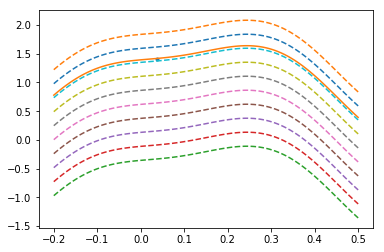

In [568]:
bprp = calc_bprp(params)
plt.plot(np.log10(bprp), np.log10(df["prot"]), ".")
plot_bprp = np.linspace(-.2, .5, 100)

plt.plot(plot_bprp, gyro_model_rossby(par, df["age"], plot_bprp, df["mass"]))
for a in np.linspace(7, 10.1, 10.):
    plt.plot(plot_bprp, gyro_model_rossby(par, a, plot_bprp, df["mass"]), ls="--")

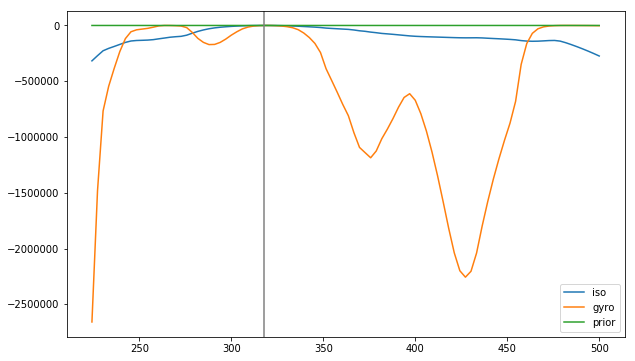

In [569]:
N = 100
eeps = np.linspace(200, 500, N)
age, feh, dis, av = df.age, df.feh, np.log(df.d_kpc*1e3), df.Av
iso, gyro, prior = [np.empty(N) for i in range(3)]
for i in range(N):
    lnparams = [eeps[i], age, feh, dis, av]
    _iso, _gyro, _prior = lnprob(lnparams, *args)
    iso[i] = _iso
    gyro[i] = _gyro
    prior[i] = _prior
    
plt.figure(figsize=(10, 6))
plt.plot(eeps, iso, label="iso")
plt.plot(eeps, gyro, label="gyro")
plt.plot(eeps, prior, label="prior")
plt.axvline(df.eep, color=".5")
plt.legend()

(-102169.1011591409, -11954824.25877591, -22.254209603299003)


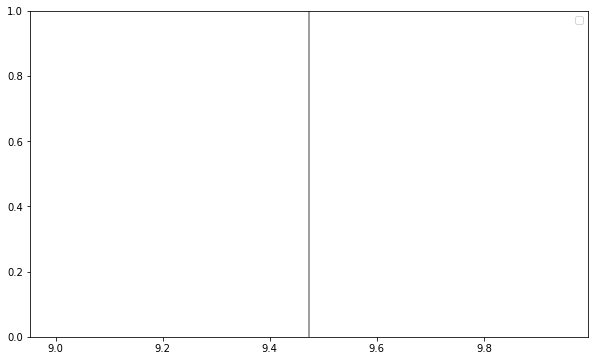

In [561]:
N = 100
ages = np.linspace(8.5, 10, N)
eep, feh, dis, av = df.eep, df.feh, np.log(df.d_kpc*1e3), df.Av
iso, gyro, prior = [np.empty(N) for i in range(3)]
for i in range(N):
    lnparams = [eep, ages[i], feh, dis, av]
    _iso, _gyro, _prior = lnprob(lnparams, *args)
    iso[i] = _iso
    gyro[i] = _gyro
    prior[i] = _prior
    
lnparams = [eep, 8.5, feh, dis, av]
print(lnprob(lnparams, *args))
    
plt.figure(figsize=(10, 6))
# plt.plot(ages, iso, label="iso")
# plt.plot(ages, gyro, label="gyro")
# plt.plot(ages, prior, label="prior")
plt.axvline(df.age, color=".5")
plt.legend()

Designing a better gyro model. First, let's load the praesepe data.

In [113]:
pr = pd.read_csv("data/praesepe.csv")

We want a gyro relation that has a small scatter for MS stars, a large scatter for M dwarfs and a large scatter for hot stars.

In [177]:
def praesepe_mean_model(log10_age, bprp):
    
    age_gyr = (10**log10_age)*1e-9
    log_age_gyr = np.log10(age_gyr)
    log_c = np.log10(bprp)
    params = [1.10469903, 0.6183025, -4.452133, 31.02877576, -47.76497323,
              0.63604919]
    log_P = params[0] + params[1]*log_c + params[2]*log_c**2 \
        + params[3]*log_c**3 + params[4]*log_c**4 + params[5]*log_age_gyr
    
    periods = 10**log_P
    
    # Hot stars
    hot_mask = bprp < .6
    periods[hot_mask] = .5
    
    # Cool stars
    cool_mask = bprp > 2.7
    periods[cool_mask] = 10**.2
    
    return periods

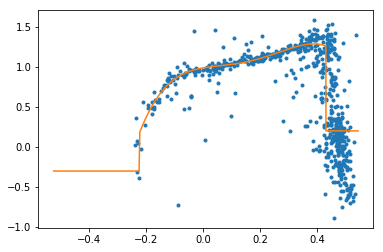

In [187]:
from stardate.lhf import gyro_model_praesepe

m = pr.prot > 0
plt.plot(np.log10(pr.bp[m] - pr.rp[m]), np.log10(pr.prot[m]), ".");
bprp = np.linspace(.3, 3.5, 1000)
plt.plot(np.log10(bprp), np.log10(praesepe_mean_model(np.log10(650*1e6), bprp)))

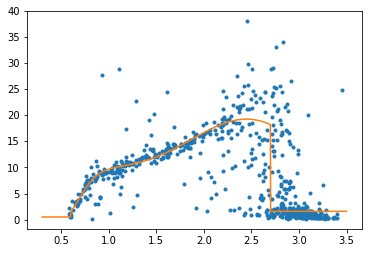

In [188]:
plt.plot(pr.bp[m] - pr.rp[m], pr.prot[m], ".");
plt.plot(bprp, praesepe_mean_model(np.log10(650*1e6), bprp))

Now draw periods from this mean model with some variance.

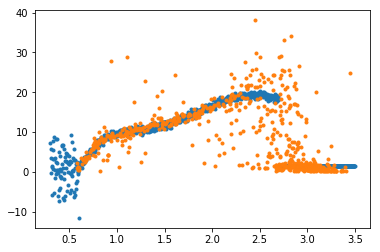

In [200]:
periods = praesepe_mean_model(np.log10(650*1e6), bprp)

hot = bprp < .6
cool = bprp > 2.7
hot_and_cool = hot + cool

periods[~hot_and_cool] += np.random.randn(len(periods[~hot_and_cool]))*.5
periods[hot] += np.random.randn(len(periods[hot]))*5

plt.plot(bprp, periods, ".")
plt.plot(pr.bp[m] - pr.rp[m], pr.prot[m], ".");
periods[bprp < .6];

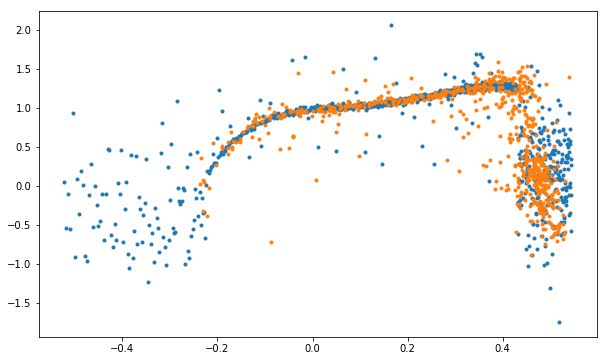

In [244]:
log_periods = np.log10(praesepe_mean_model(np.log10(650*1e6), bprp))

# hot stars
hot_cut = .6
hot = bprp < hot_cut
log_periods[hot] += np.random.randn(len(periods[hot]))*.5

# Cool stars
cool_cut = 2.7
cool = bprp > cool_cut
log_periods[cool] += np.random.randn(len(periods[cool]))*.5

# FGK stars
hot_and_cool = hot + cool
log_periods[~hot_and_cool] += np.random.randn(len(periods[~hot_and_cool]))*.02

# Binary fraction
frac_binaries = .1
ndwarfs = len(log_periods[~hot_and_cool])
nbinaries = int(ndwarfs * frac_binaries)
binary_ind = np.random.randint(0, high=ndwarfs, size=nbinaries)
log_periods[binary_ind] += np.random.randn(nbinaries)*.4

plt.figure(figsize=(10, 6))
plt.plot(np.log10(bprp), log_periods, ".")
plt.plot(np.log10(pr.bp[m] - pr.rp[m]), np.log10(pr.prot[m]), ".");

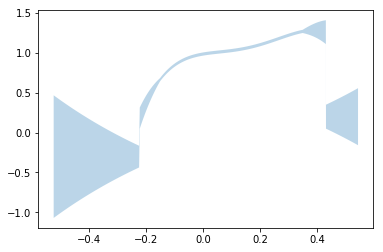

In [340]:
period_model = np.log10(praesepe_mean_model(np.log10(650*1e6), bprp))

log_bprp = np.log10(bprp)
sigma_function = .02 * np.ones_like(bprp)

cool_cut, hot_cut = .35, -.15
cool_mask = log_bprp > cool_cut
hot_mask = log_bprp < hot_cut

amp = 1.5
sigma_function[cool_mask] = .02 + np.exp((log_bprp[cool_mask] - cool_cut)*amp) - 1
sigma_function[hot_mask] = .02 + np.exp((-log_bprp[hot_mask] + hot_cut)*amp) - 1

plt.fill_between(np.log10(bprp), period_model + sigma_function, period_model - sigma_function, alpha=.3)

In [ ]:
def _lnprob(lnparams, *args):

    # Transform mass and distance back to linear.
    params = lnparams*1
    params[3] = np.exp(lnparams[3])
    params = [float(p) for p in params]

    # Unpack the args.
    mod, period, period_err, bv, mass, iso_only, gyro_only = args

    # If the prior is -inf, don't even try to calculate the isochronal
    # likelihood.
    lnpr = mod.lnprior(params)
    if not np.isfinite(lnpr):
        return -np.inf, -np.inf

    # If a B-V is not provided, calculate it.
    if bv is None:
        assert gyro_only == False, "You must provide a B-V colour if you "\
            "want to calculate an age using gyrochronology only."
        bv = calc_bv(params)

    # If the B-V value calculated is nan, return the prior.
    if not np.isfinite(bv):
        return lnpr, lnpr

    # Check that the period is a positive, finite number. It doesn't matter
    # too much what the lhf is here, as long as it is constant.
    if not period or not np.isfinite(period) or period <= 0.:
        gyro_lnlike = -.5*((5/(20.))**2) - np.log(20.)

    if mass is None:  # If a mass is not provided, calculate it.
        mass = mist.interp_value([params[0], params[1], params[2]], ["mass"])

    # Calculate a period using the gyrochronology model
    period_model = gyro_model_rossby(params[1], bv, mass)

    # Calculate the gyrochronology likelihood.
    gyro_lnlike = -.5*((period - period_model) / (period_err))**2 - np.log(period_err)

    prob = mod.lnlike(params) + gyro_lnlike + lnpr

    if not np.isfinite(prob):
        prob = -np.inf

    return prob, lnpr